In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy import odr
plt.rcParams["figure.figsize"]=10,5

In [2]:
def my_round(X , DX) :
    Ndecimal = np.int(np.ceil(np.abs(np.log10(DX))))
    DX = np.around( DX , Ndecimal )
    X = np.around( X , Ndecimal )
    return X , DX

def Q2h(P,x) : 
    return P[0] * (x + P[1])

###### Vidange d'un réservoir 

In [12]:
#Donnees EXP : 

r = 2.9 /1000. #m
r_err = 0.1 /1000. #m

rho_eau = 1000 # kg.m-3



In [13]:
ls -lrt

total 9912
drwxr-xr-x  4 Johany  staff      128 Mar 29 22:35 image/
-rwxr-xr-x@ 1 Johany  staff  4160516 Mar 30 00:40 Diapo.key*
-rw-r--r--@ 1 Johany  staff     9314 Mar 30 12:18 Vidange_reservoir.ods
-rw-r--r--@ 1 Johany  staff      269 Mar 30 13:22 Vidange_reservoir.csv
-rw-r--r--  1 Johany  staff   169421 Mar 30 13:42 LP04_Ecoulement_Parfait.ipynb
-rw-r--r--  1 Johany  staff      269 Mar 30 13:43 rdy2go.txt


In [14]:
# Formatage du fichier csv le cas echeant : 
catinit= open('Vidange_reservoir.csv','r').read()
print (catinit)

h(cm),h_err,m_init(g),m_init_err,m_end,m_end_err,t,t_err
5.0,0.1,56.1234,0.0001,258.3,0.0001,3.2,0.2
8.0,0.1,60.3,0.0001,259.1,0.0001,3.1,0.2
10.1,0.1,58.2,0.0001,260.1,0.0001,2.9,0.2
20.1,0.1,62.1,0.0001,261.2,0.0001,2.52,0.2
2.1,0.1,57.2,0.0001,258.1,0.0001,3.40,0.2



In [15]:
catinit=catinit.replace(',',' ') #Delimiter 

cat = open('rdy2go.txt','w')
cat.write(catinit)
cat.close()

In [16]:
# Lecture du fichier Formate 
Cat = np.genfromtxt('rdy2go.txt',dtype=[('h',np.float) , ('h_err',np.float) , ('m_init',np.float) , ('m_init_err',np.float), ('m_end',np.float) , ('m_end_err',np.float), ('t',np.float) , ('t_err',np.float)],skip_header=1)

Cat['h'] = Cat['h']/100. # h from cm to m 
Cat['h_err'] = Cat['h_err']/100.





In [17]:
# Preparation des données pour l'ajustement : 

DM = (Cat['m_end'] - Cat['m_init'])/1000.  # La masse écoulée en kg
DM_err = np.sqrt( Cat['m_end_err']**2 + Cat['m_init_err']**2 )

print(DM)

Qv = DM / (rho_eau * Cat['t'])
Qv_err = Qv * np.sqrt( (DM_err/DM)**2 + (Cat['t_err']/Cat['t'])**2 )

print(Qv)

Y = Qv**2
Y_err = 2 * Qv * Qv_err




[0.2021766 0.1988    0.2019    0.1991    0.2009   ]
[6.31801875e-05 6.41290323e-05 6.96206897e-05 7.90079365e-05
 5.90882353e-05]


In [18]:
## Ajustement des données par le modèle Qv^2 = a*(h + h0)

myModel = odr.Model(Q2h)
mydata = odr.RealData(x=Cat['h'],y=Y,sx=Cat['h_err'],sy=Y_err)

myodr = odr.ODR(mydata, myModel,beta0=[0., 0.])

myoutput = myodr.run()

print(myoutput.beta)
print(myoutput.sd_beta)
print('_______')



[1.50233704e-08 2.10243440e-01]
[1.74228753e-09 3.20241677e-02]
_______


[-0.0444  -0.04439 -0.04438 ...  0.22557  0.22558  0.22559]


<IPython.core.display.Javascript object>


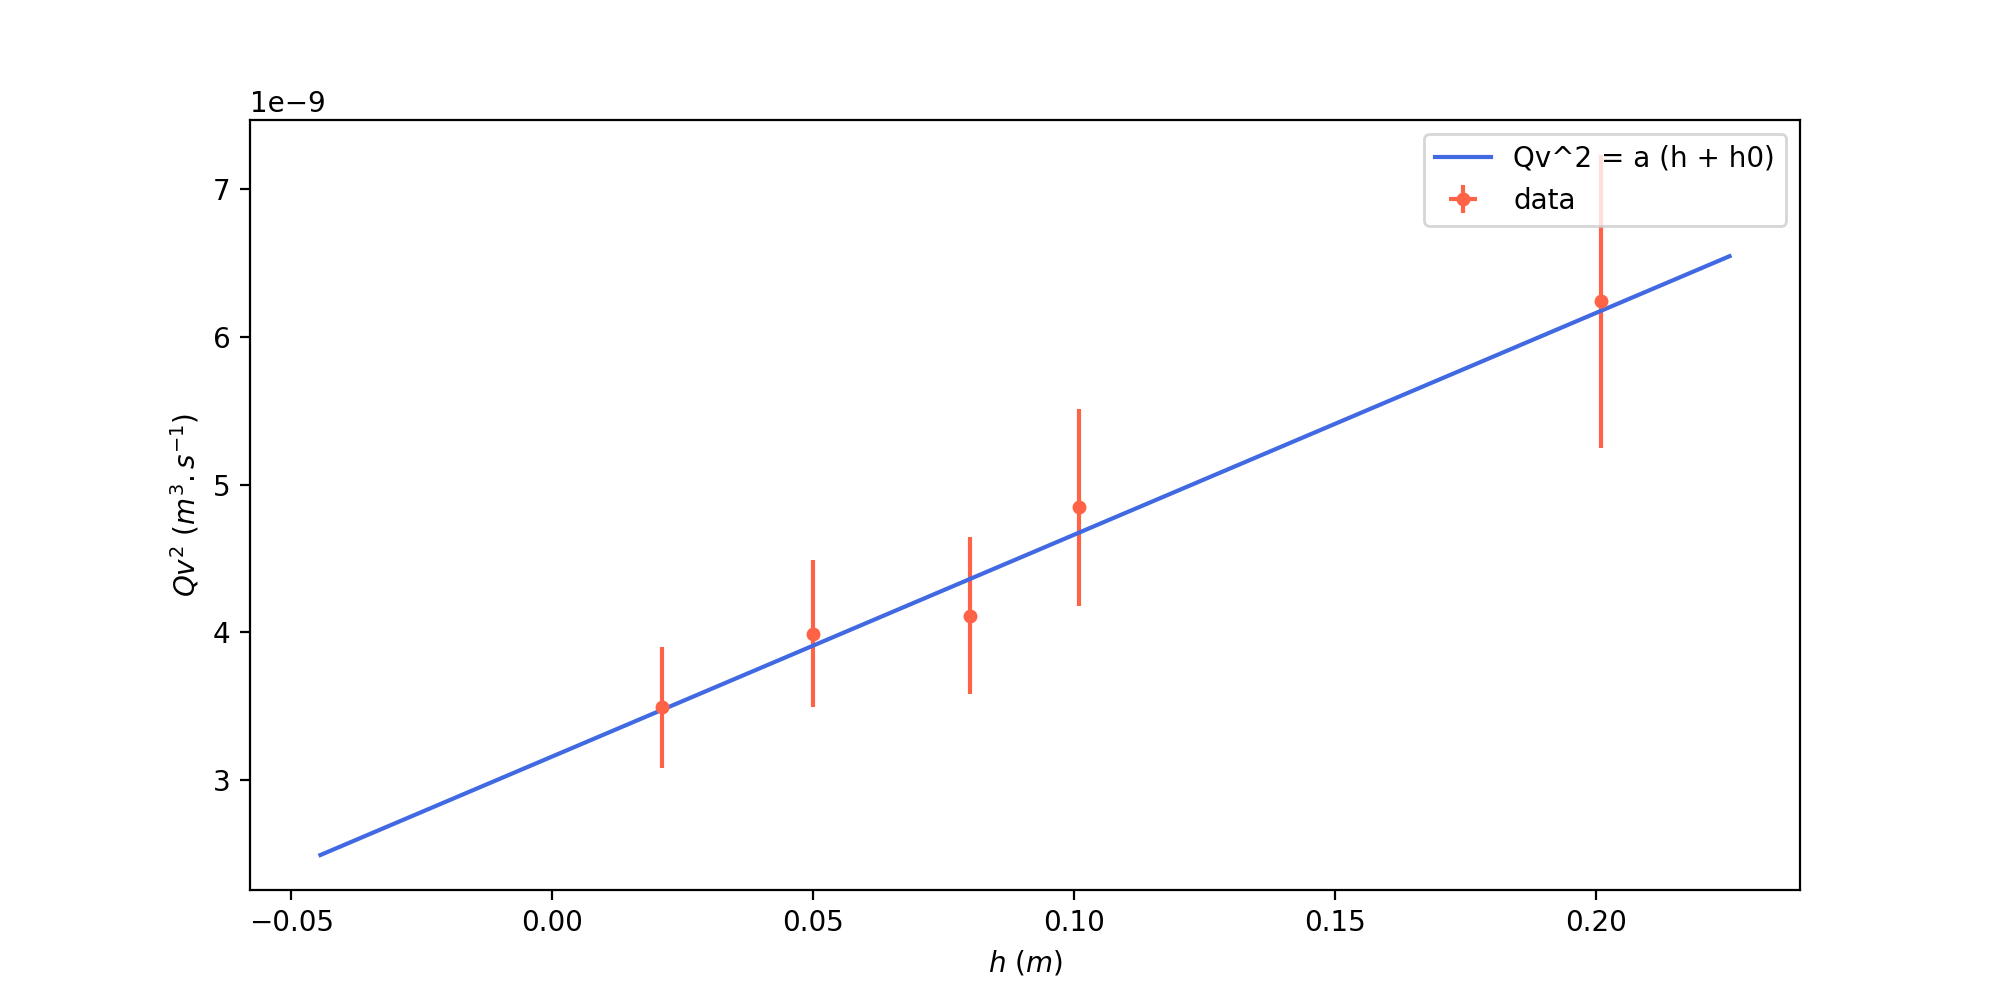

In [19]:
# Plot resultat : 

Xrange = 1.5*(np.max(Cat['h']) - np.min(Cat['h']))
Xmin = np.mean(Cat['h'])-0.5*Xrange
Xmax = np.mean(Cat['h'])+0.5*Xrange
X = np.arange(Xmin,Xmax,0.00001)

print(X)

%matplotlib notebook
plt.figure()

plt.xlabel('$h\ (m)$')
plt.ylabel('$Qv^2 \ (m^3.s^{-1})$')

plt.errorbar( Cat['h'] , Y, xerr=Cat['h_err'] , yerr=Y_err , color='tomato', fmt = 'o',markersize=4, label='data')
plt.plot (X, myoutput.beta[0]*(X + myoutput.beta[1]), 'royalblue', label='Qv^2 = a (h + h0)')



plt.legend()
plt.show()

In [21]:
# Estimation de l'accélération de pesenteur (g) : 
# Sachant que a = s^2 * 2 * g

s = np.pi * r**2
s_err = np.pi * 2 * r * r_err

g = myoutput.beta[0] / (2*s**2)

g_err = g * np.sqrt( (myoutput.sd_beta[0]/myoutput.beta[0])**2 + (2*s_err/s)**2 ) 

g_round = my_round(g , g_err)

print("l'accélération de pesenteur mesurée est de : ")
print ('g = '+str(g_round[0])+' +/- '+str(g_round[1])+' m.s-2')



l'accélération de pesenteur mesurée est de : 
g = 10.8 +/- 1.9 m.s-2
